In [1]:
import pandas as pd
from IPython.display import SVG, display
import svgpathtools as pt
import numpy as np
import re
import json

First, the simplest geometry to extract: Luxembourg's outline

In [2]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='Frontiere']/svg:path" />
        </groups>
    </xsl:template>

    <!-- indices to merge references -->
    <xsl:template match="svg:path">
        <frontier>
            <d><xsl:value-of select="@d" /></d>
            <id><xsl:value-of select="../@id" /></id>
        </frontier>
    </xsl:template>
    
</xsl:stylesheet>
'''
frontier = pd.read_xml('RGTR-Map-EN_V2.svg', stylesheet=style, xpath='/groups/*',)
frontier['d'] = frontier['d'].apply(lambda r: pt.parse_path(r).d())

Next, the actual meet: the paths and lines representing buslines. We'll convert lines t o paths for a more homogenous representation and generally apply `svgpathtools.Path` to retain only absolute coordinates:

In [3]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[starts-with(@id, 'X')]//svg:path" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='TICE']//svg:path" />
            <xsl:apply-templates select="/svg:svg/svg:g[starts-with(@id, 'X')]//svg:line" />
        </groups>
    </xsl:template>

    <!-- indices to merge references -->
    <xsl:template match="svg:path">
        <ligne>
            <d><xsl:value-of select="@d" /></d>
            <id><xsl:value-of select="../@id" /></id>
            <layer><xsl:value-of select="../../@id" /><xsl:value-of select="../../../@id" /><xsl:value-of select="../../../../@id" /></layer>
        </ligne>
    </xsl:template>
    
    <xsl:template match="svg:line">
        <ligne>
            <d>M <xsl:value-of select="@x1" />,<xsl:value-of select="@y1" /> L <xsl:value-of select="@x2" />,<xsl:value-of select="@y2" /></d>
            <id><xsl:value-of select="../@id" /></id>
            <layer><xsl:value-of select="../../@id" /><xsl:value-of select="../../../@id" /><xsl:value-of select="../../../../@id" /></layer>
        </ligne>
    </xsl:template>

    
</xsl:stylesheet>
'''
lines = pd.read_xml('RGTR-Map-EN_V2.svg', stylesheet=style, xpath='/groups/*')
lines['path'] = lines['d'].apply(lambda d: pt.Path(d))
lines['d'] = lines['path'].apply(lambda d: d.d())

lines = lines.drop_duplicates(subset=['layer', 'path'])

First attempt at some meta data:

In [4]:
lines['line'] = lines['id'].str.extract('_([0-9]{1,3}).*')[0]

Next we have a bunch of circles representings stops and locations. Some of those circles are actually perfectly circular paths, so using `Path.bbox` we'll translate them back to circles:

In [5]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[starts-with(@id, 'Ville')]/svg:g/svg:path" />
            <xsl:apply-templates select="/svg:svg/svg:g[starts-with(@id, 'Ville')]/svg:path" />
            <xsl:apply-templates select="/svg:svg/svg:g[starts-with(@id, 'Lux_Ville')]/svg:circle" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='Station_Terminus']/svg:circle" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='Station_Lux']/svg:path" />

        </groups>
    </xsl:template>

    <xsl:template match="svg:path">
        <stop>
            <d><xsl:value-of select="@d" /></d>
            <layer><xsl:value-of select="../../@id" /><xsl:value-of select="../@id" /></layer>
        </stop>
    </xsl:template>
    
    <xsl:template match="svg:circle">
        <stop-circle>
            <cx><xsl:value-of select="@cx" /></cx>
            <cy><xsl:value-of select="@cy" /></cy>
            <r><xsl:value-of select="@r" /></r>
            <layer><xsl:value-of select="../@id" /></layer>
        </stop-circle>
    </xsl:template>

    
</xsl:stylesheet>
'''
stops = pd.read_xml('RGTR-Map-EN_V2.svg', stylesheet=style, xpath='/groups/*')

def to_circle(d):
    b = pt.Path(d).bbox()
    cx = np.mean(b[:2])
    return pd.Series({'cx': cx, 'cy': np.mean(b[2:4]), 'r': cx - b[0]})    

filt = ~stops['d'].isnull()
d = stops.loc[filt, 'd'].apply(to_circle)
for k in ('cx', 'cy', 'r'):
    stops.loc[filt, k] = d[k].round(3)
stops = stops.drop('d', axis=1)

# together with rounding to 3 digits, this gets rid of overlapping
# geometries used to add a background to the station circles
#stops = stops.drop_duplicates(subset=['cx', 'cy', 'layer', 'r'])
# drop_duplicates also eliminiates concentrig circles in the city, therefore:
stops = (stops.groupby(['cx', 'cy', 'layer', (stops.r).round(0)])
         .count()
         .rename(columns={'r': 's'}).reset_index().drop('s', axis=1)
         .sort_values(['cx', 'cy', 'r'], ascending=False))  # plot smallest circle first to ensure "clickability"

Now that we have the coordinates, let's try to extract the labels:

In [6]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[starts-with(@id, 'Nom')]//svg:text" />
        </groups>
    </xsl:template>

    <xsl:template match="svg:text">
        <label>
            <transform><xsl:value-of select="@transform" /></transform>
            <label><xsl:value-of select="." /></label>
            <class><xsl:value-of select="@class" /></class>
            <layer><xsl:value-of select="../../@id" /><xsl:value-of select="../@id" /></layer>
        </label>
    </xsl:template>
        
</xsl:stylesheet>
'''
labels = pd.read_xml('RGTR-Map-EN_V2.svg', stylesheet=style, xpath='/groups/*')

d = labels['transform'].str.extract('translate\(([0-9]+(?:\.[0-9]+)?) +([0-9]+(?:\.[0-9]+)?)\)')
for i, k in enumerate(('x', 'y')):
    labels[k] = d[i].astype('float')
labels = labels.drop('transform', axis=1)
labels

,label,class,layer,x,y
0,Badanstalt,cls-96,Nom_Lux,892.93,1835.77
1,Cents-Hamm,cls-96,Nom_Lux,987.99,1886.01
2,Belair,cls-96,Nom_Lux,837.30,1867.45
3,Merl,cls-96,Nom_Lux,823.22,1872.39
4,Ehlerange,cls-96,Nom_N5,613.89,2084.79
...,...,...,...,...,...
571,Thionville,cls-90,Nom_N3,1010.46,2415.63
572,Remich,cls-90,Nom_N3,1336.34,2019.94
573,Esch-sur-Alzete,cls-92,Nom_N2,694.24,2162.80
574,Diekirch,cls-92,Nom_N2,998.87,1198.24


Let's see what those styles are all about (This time using `svgpathtools`' document methods) - turns out to be different font sizes:

In [7]:
d = pt.Document('RGTR-Map-EN_V2.svg').root
style = d.findall('svg:defs/svg:style', namespaces={'svg': 'http://www.w3.org/2000/svg'})[0].text
styles = dict(re.findall('\.([a-zA-Z\-_0-9]+)(\{[^{^}]+\})?,?', style))

In [8]:
{k: styles[k] for k in labels['class'].unique()}

{'cls-96': '',
 'cls-98': '',
 'cls-82': '{font-size:6px;}',
 'cls-91': '{font-size:8px;}',
 'cls-83': '{font-size:5px;}',
 'cls-90': '{font-size:10px;}',
 'cls-92': '{font-size:12px;}'}

Let's see if we can find a matching label for each stop:

In [9]:
def closest_label(cx, cy):
    label_coord = labels[['x', 'y']].to_numpy()
    dsq = np.sum((label_coord - np.tile([cx, cy], (label_coord.shape[0], 1)))**2, axis=1)
    return np.argmin(dsq)

stops['label'] = stops.apply(lambda s: labels.iloc[closest_label(s.cx, s.cy)].label, axis=1)

Finally, we need the line numbers:

In [10]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='Numero_Ligne']//svg:text" />
        </groups>
    </xsl:template>

    <xsl:template match="svg:text">
        <label>
            <transform><xsl:value-of select="@transform" /></transform>
            <label><xsl:value-of select="." /></label>
            <class><xsl:value-of select="@class" /></class>
            <layer><xsl:value-of select="../../@id" /><xsl:value-of select="../@id" /></layer>
        </label>
    </xsl:template>
        
</xsl:stylesheet>
'''
label_line = pd.read_xml('RGTR-Map-EN_V2.svg', stylesheet=style, xpath='/groups/*')

d = label_line['transform'].str.extract('translate\(([0-9]+(?:\.[0-9]+)?) +([0-9]+(?:\.[0-9]+)?)\)')
for i, k in enumerate(('x', 'y')):
    label_line[k] = d[i].astype('float').round(3)
d = label_line['transform'].str.extract('rotate\((-?[0-9]+(?:\.[0-9]+)?)\)')
label_line['phi'] = d[0].fillna(0).astype('float').round(3)
label_line = label_line.drop('transform', axis=1)
label_line

,label,class,layer,x,y,phi
0,111,cls-88,Numero_Ligne,901.86,1512.19,72.00
1,112,cls-88,Numero_Ligne,883.72,1518.23,72.00
2,112,cls-88,Numero_Ligne,903.53,1695.70,-90.00
3,119,cls-88,Numero_Ligne,855.67,1410.09,-72.00
4,119,cls-88,Numero_Ligne,872.04,1292.68,-90.00
...,...,...,...,...,...,...
720,328,cls-88,Numero_Ligne,1031.27,1762.71,-18.00
721,328,cls-88,Numero_Ligne,1215.99,1650.97,19.05
722,130,cls-88,Numero_Ligne,365.27,861.53,18.00
723,424,cls-88,Numero_Ligne,958.49,1901.98,72.00


Can we match labels to lines? Well, maybe not. But at least, can we find bits of lines that belong together? Should require some graph traversal:

In [11]:
def distance(p1, p2):
    return np.sqrt((p1.real - p2.real)**2 + (p1.imag - p2.imag)**2)

def ends_touch(g1, g2, eps=1):
    if g1 == g2:
        return True
    
    for p1 in (g1.start, g1.end):
        for p2 in (g2.start, g2.end):
            if distance(p1, p2) < eps:
                return True
    return False

In [12]:
stack = [144]
visited = set()
linked = set(stack)
while stack:
    cur = stack.pop()
    visited.add(cur)
    p = lines['path'].loc[cur]
    neighbors = set(lines[lines['path'].apply(lambda p2: ends_touch(p, p2, eps=.1))].index.values)
    linked = linked.union(neighbors)
    stack += list(linked.difference(visited))
linked
    

{144, 146, 148, 188, 190, 192, 236, 1694}

Might be more efficient to sweep over the entire array:

In [13]:
p = lines['path'].iloc[101]

def neighbors(path):
    n = set(lines[lines['path'].apply(lambda p2: ends_touch(path, p2, eps=.1))].index.values)
    return n
    
    
target = (p.start, p.end)
#stack = list(lines['path'].apply(neighbors))
neighborhood = []
#while stack:
#    cur = stack.pop()
for cur in lines['path'].apply(neighbors):
    linked = [n for n in neighborhood if n.intersection(cur)]
    joined = set(cur)
    for n in linked:
        neighborhood.remove(n)
        joined = joined.union(n)
    neighborhood.append(joined)


Turn the new neighborhood list into a lookup table, then check for every group of paths whether we can get a line-name from a layer

In [14]:
line_group = {m: min(n) for n in neighborhood for m in n}
lines['group'] = lines.apply(lambda r: line_group[r.name], axis=1)

# try to find a line for every group
group_to_line = dict(lines.groupby(['group', 'line']).count().reset_index()[['group', 'line']].itertuples(index=False, name=None))
lines['line_estimated'] = lines.apply(lambda l: group_to_line.get(l.group), axis=1)

In [15]:
lines['line_estimated'].astype(float).max()

961.0

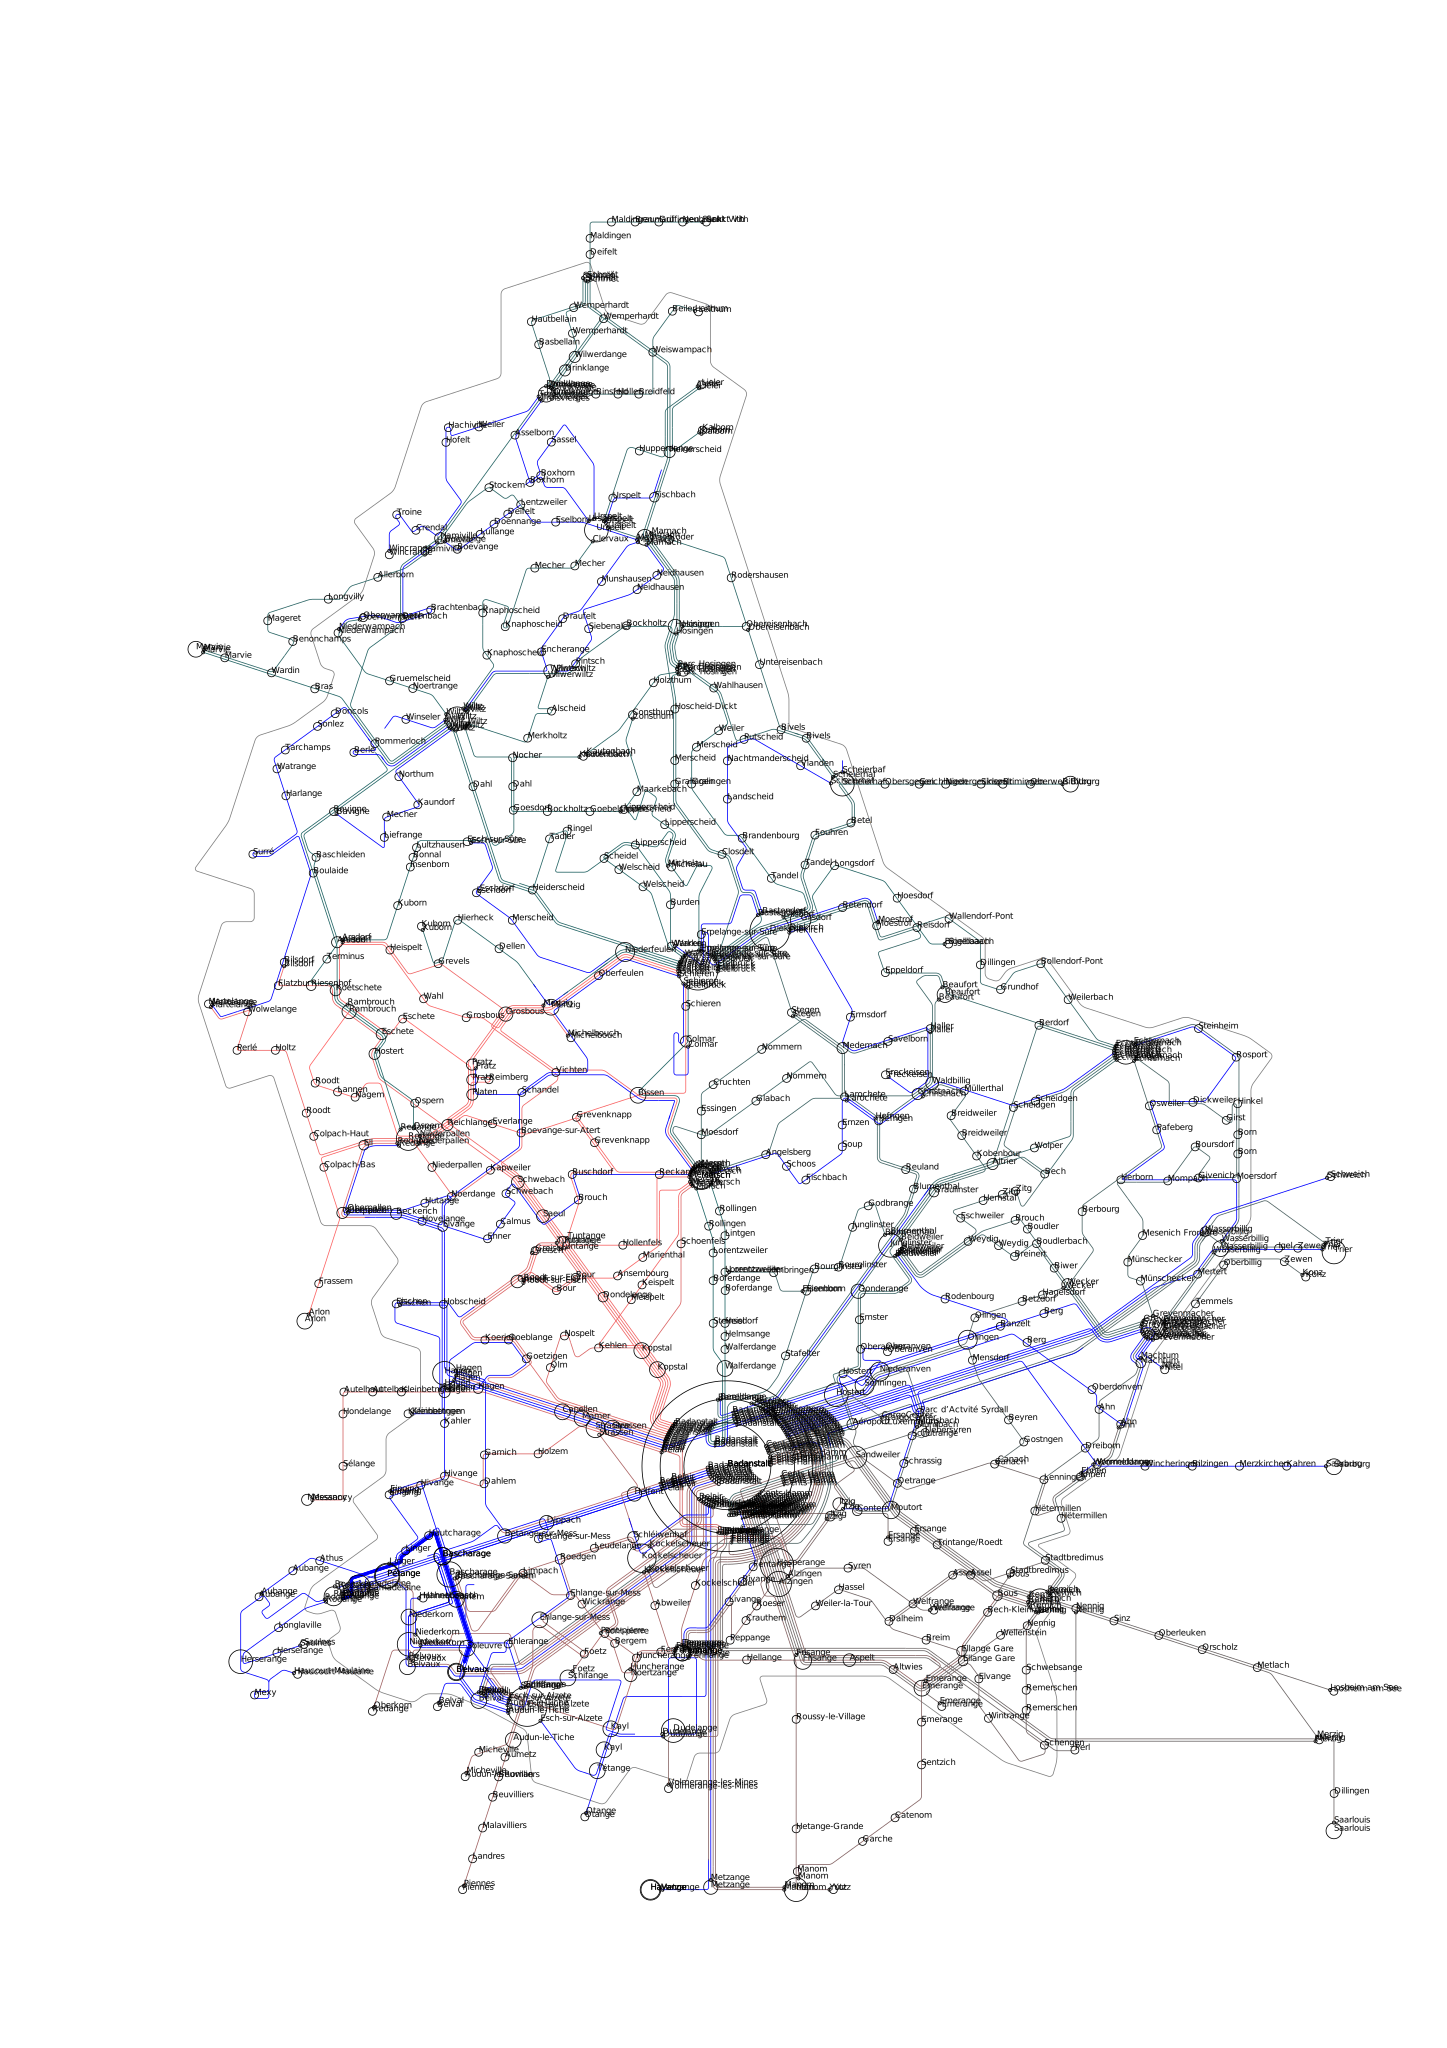

In [16]:
def path(r, stroke='black'):
    return f'<path d="{r.d}" style="fill: none; stroke: {stroke};" />'

def circle(r, stroke='black', fill='none'):
    return f'<circle cx="{r.cx}" cy="{r.cy}" r="{r.r}" style="fill: {fill}; stroke: {stroke};" />'

def text(r):
    return text_raw(r.x, r.y, r.label)

def text_raw(x, y, text):
    return f'<text x="{x}" y="{y}" style="font-size: 8pt;">{text}</text>'

def color(line):
    if not line.line_estimated:
        return 'blue'
    red = int(float(line.line_estimated) / 961 * 255)
    return f'rgb({red}, 100, 100)'


tags = list(frontier.apply(path, axis=1, stroke='gray'))
tags += list(lines.apply(lambda l: path(l, stroke=color(l)), axis=1))
tags += list(stops.apply(circle, axis=1))
#tags += list(labels.apply(text, axis=1))
tags += list(stops.apply(lambda r: text_raw(r.cx, r.cy, r.label), axis=1))

tags += list(lines.query('line_estimated=="328"').apply(path, axis=1, stroke='red'))


svg = '<?xml version="1.0" encoding="UTF-8"?><svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 0 1829.84 2588.96">{}</svg>'
SVG(svg.format('\n'.join(tags)))

Create JSON export files

In [17]:
export = {
    'frontier': frontier['d'].iloc[0],
    'lines': [
        {'id': group, 'line': line, 'd': d}
        for group, d, line in (
            lines.groupby('group')
            .agg({'d': list, 'line_estimated': min})
            .rename(columns={'line_estimated': 'line'})
            .fillna(0)
            .itertuples(name=None, index=True)
        )
    ], 'stops': [
       {'id': s.Index, 'label': s.label, 'cx': s.cx, 'cy': s.cy, 'r': s.r, 'layer': s.layer}
       for s in stops.itertuples()
    ]
}
with open('busmap.json', 'w') as f:
    json.dump(export, f)

### Export for editing

In [48]:
{s['layer'] for s in export['stops']}

{'Lux_Ville',
 'Station_Lux',
 'Station_Terminus',
 'Ville_N2',
 'Ville_N3',
 'Ville_N4',
 'Ville_N5'}

In [53]:
len(export['lines'])

245

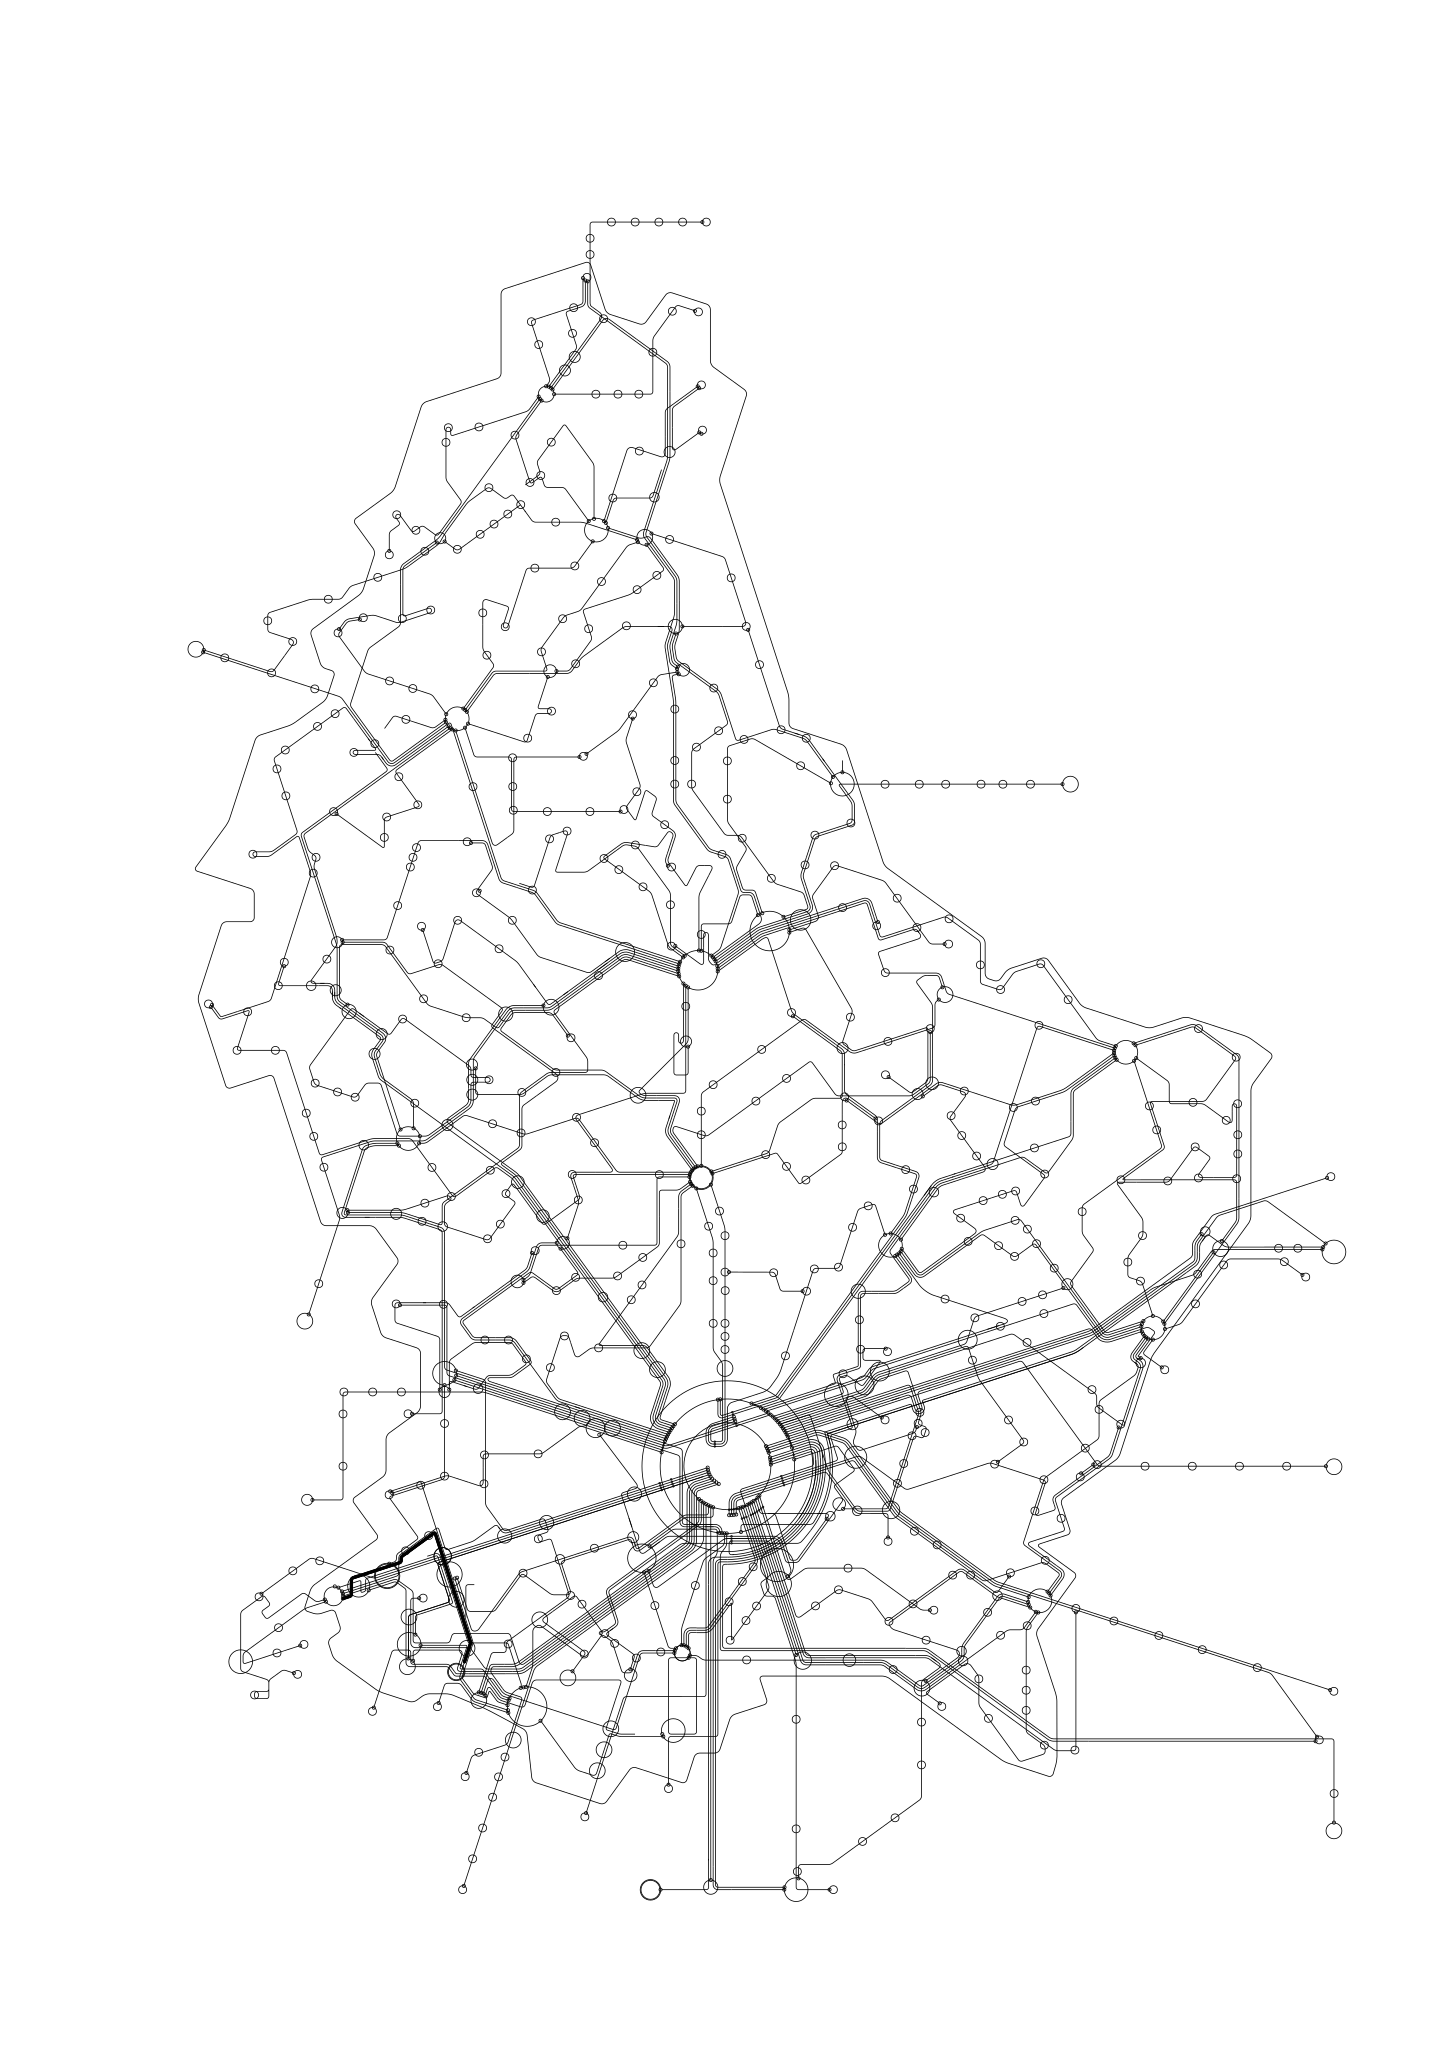

In [56]:
tags = []

def group(*tags, id=None):
    tags = '\n'.join(tags)
    if id:
        return f'<g id="{id}">{tags}</g>'
    return f'<g>{tags}</g>'

def path(d, stroke='black'):
    return f'<path d="{d}" style="fill: none; stroke: {stroke};" />'

def circle(cx, cy, r=1, stroke='black', fill='none'):
    return f'<circle cx="{cx}" cy="{cy}" r="{r}" style="fill: {fill}; stroke: {stroke};" />'

# frontier
tags.append(group(path(export['frontier']), id='frontier'))

# lines
l = (group(*(path(d) for d in line['d']), id=f'{i:03d}-{line["line"]}') for i, line in enumerate(export['lines']))
tags.append(group(*l, id='lines'))

# stops
s = (group(circle(s['cx'], s['cy'], s['r']), id=f'{i:03d}-{s["label"]}') for i, s in enumerate(export['stops']) if not s['layer'].startswith('Station'))
tags.append(group(*s, id='stops'))

# stations
s = (group(circle(s['cx'], s['cy'], s['r']), id=f'{i:03d}-{s["label"]}') for i, s in enumerate(export['stops']) if s['layer'].startswith('Station'))
tags.append(group(*s, id='stations'))

svg = '<?xml version="1.0" encoding="UTF-8"?><svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 0 1829.84 2588.96">{}</svg>'
svg = svg.format('\n'.join(tags))

with open('editable_map.svg', 'w+', encoding='utf-8') as f:
    f.write(svg)

SVG(svg)

In [58]:
stops.layer.unique()

array(['Ville_N5', 'Ville_N4', 'Station_Terminus', 'Ville_N3',
       'Station_Lux', 'Ville_N2', 'Lux_Ville'], dtype=object)